# Cross-modality integration of single-cell resolution Xenium in situ data and whole transcriptome Visium data

This tutorial provides detailed instructions on how to integrate Xenium in situ data with Visium data performed on serial sections. It also includes functions for integrating high-resolution histology images, allowing visualization of both morphological details and molecular information.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list('WhRd',["#e5e5e5", "#fffacd", "red", "darkred"], N=256)  

In [2]:
import pySTIM as pst

In [3]:
adata_vis = pst.load_Visium_data()
adata_xe = pst.load_Xenium_data()

Load in Visium and Xenium data

In [4]:
adata_xe.obsm["spatial"] = np.array(adata_xe.obs[['x_centroid', 'y_centroid']]) ## The original cell coords for Xenium data are stored in 'x_centroid', 'y_centroid'
adata_vis.obsm["spatial"] = np.array(adata_vis.obs[['Y_coords', 'X_coords']]) ## The original spot coords for Visium data are stored in 'X_coords', 'Y_coords'

We can visualize the marker gene expression of the sham kidneys from the two spatial transcriptomic platforms:

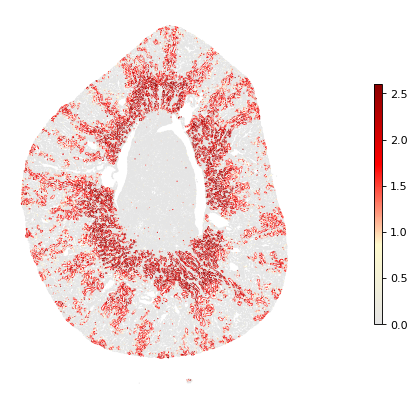

In [5]:
pst.plot_scatter(adata_xe, genes = "Slc7a13", ptsize=1, seed=123, dpi=80, alpha=1, legend_col=1, cmap = cmap)

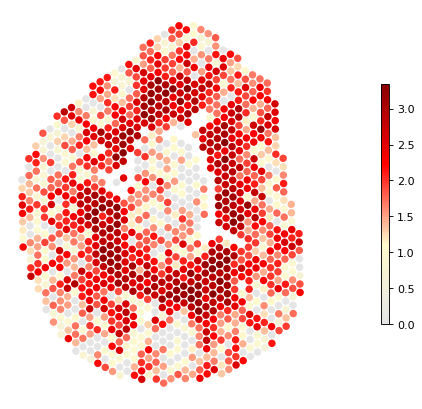

In [6]:
pst.plot_scatter(adata_vis, genes = "Slc7a13", ptsize=45, seed=123, dpi=80, alpha=1, legend_col=1, cmap = cmap)

## Aligning Spatial Transcriptomic Datasets

Several packages are available for aligning spatial transcriptomic datasets, including:[PASTE](https://paste-bio.readthedocs.io/en/latest/index.html), [STalign](https://jef.works/STalign/), and [SpatialData](https://spatialdata.scverse.org/en/latest/index.html). Since our datasets come from serial tissue sections, we aligned the two datasets through manual landmark selection using [Xenium Explorer](https://www.10xgenomics.com/support/software/xenium-explorer/latest/tutorials/xe-image-alignment). After registration, you can save the landmark points and transformation matrix for subsequent analysis.

In [5]:
H = np.array([[0.09405798593520641,3.41158653187994,-959.2731416178372],
             [3.41158653187994,-0.09405798593520641,-1528.8859782583281],
             [0,0,1]])

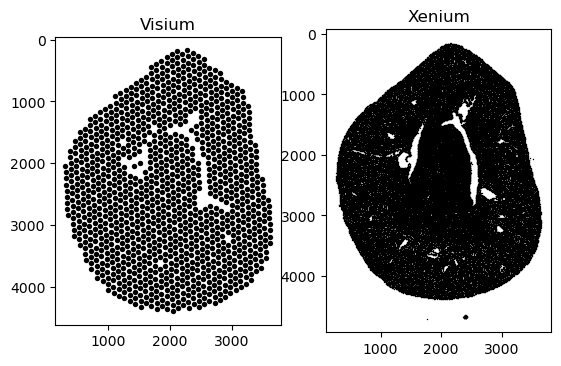

In [7]:
aligned_points = pst.align_adata(H, adata_xe, adata_vis)

In [8]:
adata_vis.obsm["spatial"] = aligned_points

After alignment, we can obtain the alignment "anchors" which stores the mapping between Xenium cells and Visium spots. We can check the performance of cross-modality alignment by calculating the gene expression correspondance between Visium spots and Xenium pseudo-Visium spots. 

Original Xenium cell #: 85880, mapped Xenium cell #: 23747


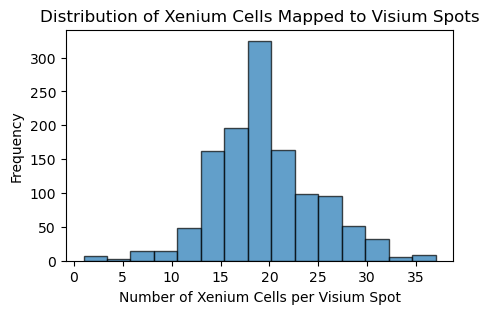

Calculating pseudo-Visium data.....
Top 5 correlated spatial gene expression .....
         pearson_r
Acsm3     0.856231
Cyp7b1    0.829400
Slc12a1   0.789112
Bcat1     0.788783
Slc7a13   0.769708
Aqp1      0.767921
Slc14a2   0.748023
Ptger3    0.746897
Fgf1      0.746502
Epcam     0.745752


In [11]:
anchor_dict, Xenium_agg_gene_df = pst.register_xenium_visium(adata_xe, adata_vis, spot_diameter=55)

To visualize and compare the spatial gene expression patterns between the Visium and the pseudo-Visium data.

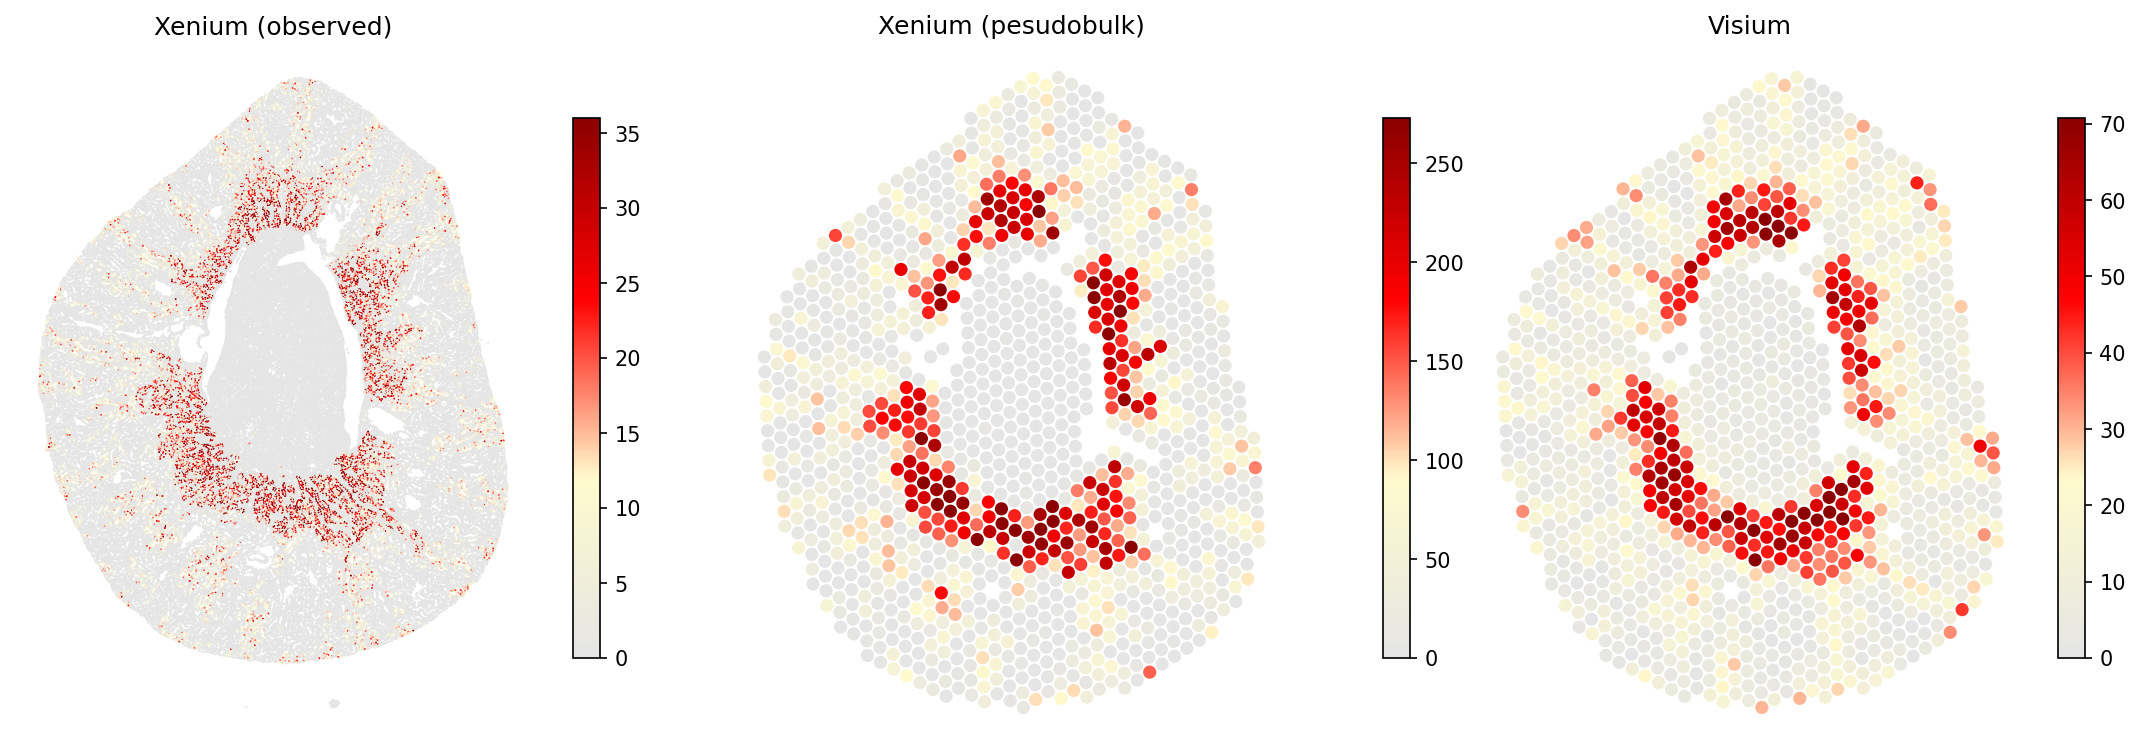

In [12]:
gene = "Acsm3"
pst.plot_compare(adata_xe, Xenium_agg_gene_df, adata_vis, gene = gene, cmap=cmap, save = False)

Directly overlap Visium spot expression on Xenium cell expression. 

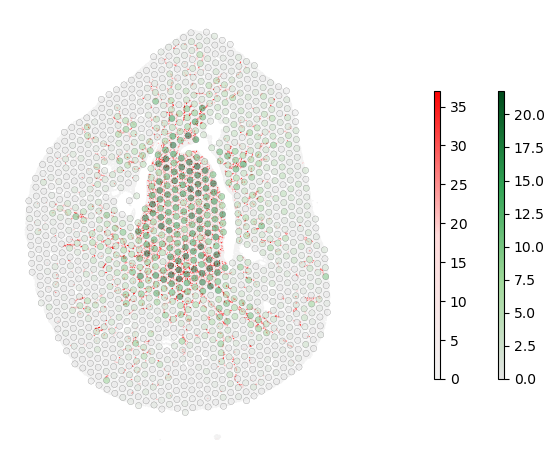

In [22]:
gene = "Slc12a1"
pst.plot_integrate(adata_vis, adata_xe, gene = gene, ptsize_vis=20, ptsize_xe=1, color_bar = True)

## Adding histology images for visualization

To add pre-aligned morphology images, provide both the morphology image path and the DAPI image path, along with the affine transformation matrix/landmark points to the function `add_img()`.

In [10]:
adata_xe = add_img(adata_xe, img_path = 'Xenium_shamR.tif', dapi_path = 'morphology.ome.tif', transform = 'Xenium_shamR_alignment_files/keypoints.csv', scale_factor=0.2125, library_key="spatial")

Visualize the cell type annotation or gene expression information on histology image data.

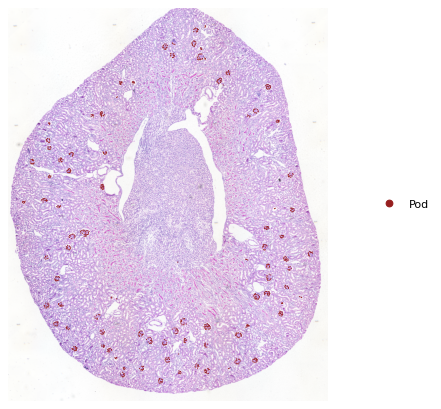

In [14]:
pst.plot_scatter_img(adata_xe[adata_xe.obs.celltype == "Pod"], 
                 color_by = "celltype", ptsize=1, 
                 image = True, image_key = "spatial", 
                 seed=123, dpi=80, alpha=1, legend_col=1)

To focus on a specific region of tissue morphology and molecular information, specify the coordinates of the desired region using the `x_lims` and `y_lims` parameters in the `plot_scatter_img()` function. In this example, we visualize the expression of *Nphs2*, a typical marker for podocytes.

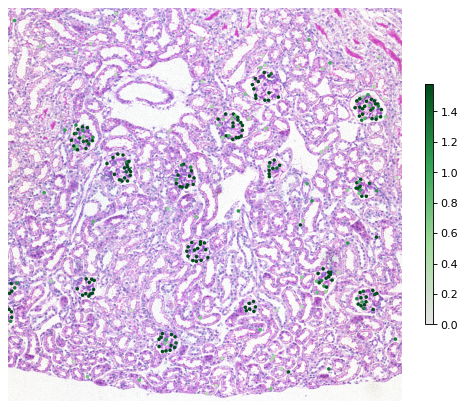

In [11]:
cmap_greens = mcolors.LinearSegmentedColormap.from_list("Greens", ["#e5e5e5", "#a1d99b", "#31a354", "#004a1b"])

pst.plot_scatter_img(adata_xe, xlims = [1500,2500], ylims = [3400,4400],
                 genes = "Nphs2", ptsize=10, cmap = cmap_greens,
                 image = True, image_key = "spatial", 
                 seed=123, dpi=80, alpha=1, legend_col=1)